# Generating Python Programs with Bloom

Get your key from [hugging hub](https://huggingface.co/docs/hub/security-tokens) and insert it to the ``InferenceAPI`` using the model tag ``bigscience/bloom`` to run the full 176B parameter Bloom text2text model on Hugging Face's infastructure.

In [12]:
from huggingface_hub import InferenceApi
import get_tokens

inference = InferenceApi("bigscience/bloom",token=get_tokens.get_hugging_face_token())

## Inference wrapper

Wrap up inference into a function call ``infer_greedy``, which picks the most likely token to finish a given sentence. Notice that the prompt is given as separate input, and ``stop_tokens`` can be given to stop text generation when a specific token is found.

In [155]:
import time

def infer_greedy(prompt,
                 query,
                 stop_tokens = None,
                 # max_length = 128,
                 max_length = 512,
                 temperature=1e-6,
                 return_full_text = False,
                 verbose = False
):
    
    new_prompt = f'{prompt}\n{query}\n'

    params = {
        "max_new_tokens": max_length,
        "top_k": None,
        "top_p": None,
        "temperature": temperature,
        "do_sample": False,
        "seed": 42, #useless
        "early_stopping":None,
        "no_repeat_ngram_size":None,
        "num_beams":None,
        "return_full_text":return_full_text
    }
    s = time.time()
    response = inference(new_prompt, params=params)
    proc_time = time.time()-s
    if verbose:
        print(f"Inference time {proc_time} seconds")
        
    if isinstance(response, dict):
        assert list(response.keys()) == ['error']
        print(f"Failed with: {response}")
        raise ValueError('sth went wrong')

    response = response[0]['generated_text']
    #print(response)
    response = response[(response.find(query) + len(query) + 1):]

    if stop_tokens is not None:
        if verbose:
            print('Stopping')
        for stoken in stop_tokens:
            if stoken in response:
                response = response[:response.index(stoken)]

    return response

## Prompt Engineering

Let's play with Bloom to try to generate Python from natural language as in the [*Code as Policies*](https://arxiv.org/abs/2209.07753) paper. Our job here is to tune the prompt in order to sucessfully generate the same results. This might be challenging as our model is text2text and not text2code, yet it has seen codebases as part of its pretraining, so let's see.

### Pure Python

In [156]:
prompt_pure_python = '''
# Python script
# get the variable a.
ret_val = a
# get the average of variables a, b and c
ret_val = (a + b + c) / 3
'''.strip()

In [157]:
print(len(prompt_pure_python))
print(prompt_pure_python)

117
# Python script
# get the variable a.
ret_val = a
# get the average of variables a, b and c
ret_val = (a + b + c) / 3


In [158]:
# examples greedy decoding
queries = ['# find the sum of variables a and b.',
           '# find the sum of numbers in a list called values.',
           '# find the difference between the max and min numbers in a list called xs.',
           '# see if any number is divisible by 3 in a list called xs.'
]

for q in queries:
    resp = infer_greedy(prompt_pure_python, q, max_length=39, stop_tokens=['#'])
    print(q)
    print(resp)
    print('==' * 48)

# find the sum of variables a and b.
ret_val = a + b

# find the sum of numbers in a list called values.
ret_val = sum(values)

# find the difference between the max and min numbers in a list called xs.
ret_val = max(xs) - min(xs)

# see if any number is divisible by 3 in a list called xs.
ret_val = any(x % 3 == 0 for x in xs)



Pretty good with only one extra prompt example, compared to the GPT-3 ``code-davinci`` model of the original paper.

### NumPy programs

In [159]:
prompt_np = '''
import numpy as np
# move all points in pts_np to the right.
ret_val = pts_np + [0.3, 0, 0]
# move a pt_np to the top.
ret_val = pt_np + [0, 0.3, 0]
# move a pt_np to the front.
ret_val = pt_np + [0, 0, 0.3]
# get the back most point in pts_np.
ret_val = pts_np[np.argmin(pts_np[:, 2])]
'''.strip()

In [30]:
print(prompt_np)

import numpy as np
# move all points in pts_np to the right.
ret_val = pts_np + [0.3, 0, 0]
# move a pt_np to the top.
ret_val = pt_np + [0, 0.3, 0]
# move a pt_np to the front.
ret_val = pt_np + [0, 0, 0.3]
# get the back most point in pts_np.
ret_val = pts_np[np.argmin(pts_np[:, 2])]


In [160]:
# examples greedy decoding
queries = ['# get the left most point in pts_np.',
           '# get the center of pts_np.',
           '# the closest point in pts_np to pt_np.',
           '# points in pts_np right from pt_np.',
           '# points in pts_np top from pt_np.'
]

for q in queries:
    resp = infer_greedy(prompt_np, q, max_length=50, stop_tokens=['#'])
    print(q)
    print(resp)
    print('==' * 48)

# get the left most point in pts_np.
ret_val = pts_np[np.argmin(pts_np[:, 0])]

# get the center of pts_np.
ret_val = np.mean(pts_np, axis=0)

# the closest point in pts_np to pt_np.
ret_val = pts_np[np.argmin(np.linalg.norm(pt_np - pts_np, axis=1))]

# points in pts_np right from pt_np.
ret_val = pts_np[np.argwhere(pts_np[:, 0] > pt_np[0])]

# points in pts_np top from pt_np.
ret_val = pts_np[np.argmin(np.abs(pts_np[:, 0] - pt_np[0]))]



Wow, remember this is text2text and not text2code model. Amazing. Maybe we can use Bloom out-of-the-box for spatial reasoning.

### Using Scene Context

In [161]:
prompt_context = '''
objects = ['green block', 'green bowl', 'yellow block', 'yellow bowl']
# the blocks.
ret_val = ['green block', 'yellow block']
objects = ['red block', 'red bowl', 'blue block', 'blue bowl']
# the fire-colored bowl.
ret_val = 'red bowl'
# the other one.
ret_val = 'blue bowl'
'''.strip()

In [33]:
print(prompt_context)

objects = ['green block', 'green bowl', 'yellow block', 'yellow bowl']
# the blocks.
ret_val = ['green block', 'yellow block']
objects = ['red block', 'red bowl', 'blue block', 'blue bowl']
# the fire-colored bowl.
ret_val = 'red bowl'
# the other one.
ret_val = 'blue bowl'


In [162]:
context = "objects = ['blue bowl', 'red block', 'red bowl', 'blue block']"
query = '# the bowls.'

extended_prompt = f'{prompt_context}\n{context}'
resp = infer_greedy(extended_prompt, query, max_length=25, stop_tokens=['#', 'objects = ['])
print(context)
print(query)
print(resp)

objects = ['blue bowl', 'red block', 'red bowl', 'blue block']
# the bowls.
ret_val = ['blue bowl','red bowl']



In [163]:
context = "objects = ['blue bowl', 'red block', 'red bowl', 'blue block']"
query = '# sea-colored block.'

extended_prompt = f'{prompt_context}\n{context}'
resp = infer_greedy(extended_prompt, query, max_length=25, stop_tokens=['#', 'objects']).strip()
print(context)
print(query)
print(resp)

objects = ['blue bowl', 'red block', 'red bowl', 'blue block']
# sea-colored block.
ret_val = 'blue block'


In [164]:
context = f'{context}\n{query}\n{resp}'

query = '# the other block.'

extended_prompt = f'{prompt_context}\n{context}'
resp = infer_greedy(extended_prompt, query, max_length=25, stop_tokens=['#', 'objects'])
print(context)
print(query)
print(resp)

objects = ['blue bowl', 'red block', 'red bowl', 'blue block']
# sea-colored block.
ret_val = 'blue block'
# the other block.
ret_val ='red block'



Pretty good but the tasks seem simple. Let's assume open-ended object vocabulary of household items. Does it generalize to arbitrary semantic concepts?

In [165]:
prompt_context_household = '''
objects = ['coca-cola', 'bowl', 'cup', 'cereal box', 'plate', 'iPhone', 'knife', 'banana']
# the bowl.
ret_val = 'bowl'
# the edible items.
ret_val = ['coca-cola', 'cereal box', 'banana']
# the kitchenware.
ret_val = ['bowl', 'cup', 'plate', 'knife']
# the brand items.
ret_val = ['coca-cola', 'iPhone']
'''.strip()

In [38]:
print(prompt_context_household)

objects = ['coca-cola', 'bowl', 'cup', 'cereal box', 'plate', 'iPhone', 'knife', 'banana']
# the bowl.
ret_val = 'bowl'
# the edible items.
ret_val = ['coca-cola', 'cereal box', 'banana']
# the kitchenware.
ret_val = ['bowl', 'cup', 'plate', 'knife']
# the brand items.
ret_val = ['coca-cola', 'iPhone']


In [166]:
context = "objects = ['plate', 'juice box', 'flashlight', 'keyboard', 'Sprite', 'Oreo']"
queries = ['# the torch.',
           '# the edible items.',
           '# the electronic devices.',
           '# the drinks.',
           '# the brand items.',
           '# the fluid containers.',
           '# the most expensive item.'
]

for q in queries:
    resp = infer_greedy(prompt_context_household, f'{context}\n{q}', max_length=25, stop_tokens=['#', 'objects'])
    print(context)
    print(q)
    print(resp)
    print('==' * 48)

objects = ['plate', 'juice box', 'flashlight', 'keyboard', 'Sprite', 'Oreo']
# the torch.
ret_val = 'flashlight'

objects = ['plate', 'juice box', 'flashlight', 'keyboard', 'Sprite', 'Oreo']
# the edible items.
ret_val = ['juice box', 'Oreo']

objects = ['plate', 'juice box', 'flashlight', 'keyboard', 'Sprite', 'Oreo']
# the electronic devices.
ret_val = ['flashlight', 'keyboard']

objects = ['plate', 'juice box', 'flashlight', 'keyboard', 'Sprite', 'Oreo']
# the drinks.
ret_val = ['juice box', 'Sprite']

objects = ['plate', 'juice box', 'flashlight', 'keyboard', 'Sprite', 'Oreo']
# the brand items.
ret_val = ['Sprite', 'Oreo']

objects = ['plate', 'juice box', 'flashlight', 'keyboard', 'Sprite', 'Oreo']
# the fluid containers.
ret_val = ['juice box', 'Sprite']

objects = ['plate', 'juice box', 'flashlight', 'keyboard', 'Sprite', 'Oreo']
# the most expensive item.
ret_val = 'flashlight'



That's cool! It recognizes different categories of objects and some of their properties (brand, edible, c!ontainer etc.) even for new words and concepts not appearing in prompt. Apparently flashlights are more expensive than keyboards though :P

### Using 1st-Party APIs

In [167]:
prompt_api = '''
from utils import get_pos, pick_and_place
objects = ['gray block', 'gray bowl']
# put the gray block on the gray bowl.
pick_and_place('gray block', 'gray bowl')
objects = ['purple block', 'purple bowl']
# move the purple bowl toward the left.
target_pos = get_pos('purple bowl') + [-0.3, 0]
pick_and_place('purple bowl', target_pos)
'''.strip()

In [82]:
print(prompt_api)

from utils import get_pos, pick_and_place
objects = ['gray block', 'gray bowl']
# put the gray block on the gray bowl.
pick_and_place('gray block', 'gray bowl')
objects = ['purple block', 'purple bowl']
# move the purple bowl toward the left.
target_pos = get_pos('purple bowl') + [-0.3, 0]
pick_and_place('purple bowl', target_pos)


In [168]:
context = "objects = ['blue bowl', 'red block', 'red bowl', 'blue block']"
queries = ['# move the red block a bit to the right.',
           '# put the blue block on the bowl with the same color.',
           '# put the red block in the matching bowl.',
]

extended_prompt = f'{prompt_api}\n{context}'
for q in queries:
    resp = infer_greedy(extended_prompt, q, max_length=60, stop_tokens=['#', 'objects'])
    print(context)
    print(q)
    print(resp)
    print('==' * 48)

objects = ['blue bowl', 'red block', 'red bowl', 'blue block']
# move the red block a bit to the right.
target_pos = get_pos('red block') + [0.2, 0]
pick_and_place('red block', target_pos)

objects = ['blue bowl', 'red block', 'red bowl', 'blue block']
# put the blue block on the bowl with the same color.
pick_and_place('blue block', 'blue bowl')

objects = ['blue bowl', 'red block', 'red bowl', 'blue block']
# put the red block in the matching bowl.
pick_and_place('red block','red bowl')



Picks up immediately, but like scene context, this one seems simple

### Combining Context, 1st-Party and 3rd-Party APIs

In [169]:
prompt_combined = '''
import numpy as np
from utils import get_pos, pick_and_place, get_obj_name
objects = ['cyan block', 'cyan bowl', 'pink bowl']
# put the cyan block in cyan bowl.
pick_and_place('cyan block', 'cyan bowl')
objects = ['gray block', 'silver block', 'gray bowl']
# place the cyan block on the cyan bowl.
pick_and_place('cyan block', 'cyan bowl')
objects = ['gray block', 'silver block', 'gray bowl']
# place the top most block on the gray bowl.
blocks = ['gray block', 'silver block']
positions = np.array([get_pos(name) for name in blocks])
name = blocks[np.argmax(positions[:,1])]
pick_and_place(name, 'gray bowl')
objects = ['purple block', 'purple bowl']
# put the purple bowl to the left of the purple block.
target_pos = get_pos('purple block') + [-0.3, 0]
pick_and_place('purple bowl', target_pos)
objects = ['green block', 'yellow bowl', 'yellow block', 'green bowl']
# move the left most bowl toward the right by 3cm.
bowls = ['green bowl', 'yellow bowl']
positions = np.array([get_pos(name) for name in bowls])
name = bowls[np.argmin(positions[:,0])]
target_pos = get_pos(name) + [0.03, 0]
pick_and_place(name, target_pos)
objects = ['green block', 'yellow bowl', 'yellow block', 'green bowl']
# place the green block in the bowl of a different color.
pick_and_place('green block', 'yellow bowl')
objects = ['green block', 'yellow block', 'red bowl', 'blue bowl']
# find the object that is in the middle of the blocks.
target_pos = np.mean(np.array([get_pos('green block'), get_pos('yellow block')]), axis=0)
get_obj_name(target_pos)
'''.strip()

In [87]:
print(prompt_combined)

import numpy as np
from utils import get_pos, pick_and_place, get_obj_name
objects = ['cyan block', 'cyan bowl', 'pink bowl']
# put the cyan block in cyan bowl.
pick_and_place('cyan block', 'cyan bowl')
objects = ['gray block', 'silver block', 'gray bowl']
# place the cyan block on the cyan bowl.
pick_and_place('cyan block', 'cyan bowl')
objects = ['gray block', 'silver block', 'gray bowl']
# place the top most block on the gray bowl.
blocks = ['gray block', 'silver block']
positions = np.array([get_pos(name) for name in blocks])
name = blocks[np.argmax(positions[:,1])]
pick_and_place(name, 'gray bowl')
objects = ['purple block', 'purple bowl']
# put the purple bowl to the left of the purple block.
target_pos = get_pos('purple block') + [-0.3, 0]
pick_and_place('purple bowl', target_pos)
objects = ['green block', 'yellow bowl', 'yellow block', 'green bowl']
# move the left most bowl toward the right by 3cm.
bowls = ['green bowl', 'yellow bowl']
positions = np.array([get_pos(name) for n

In [170]:
context = "objects = ['red block', 'blue bowl', 'blue block', 'red bowl']"
queries = ['# put the red block in blue bowl.',
           '# place the blocks in bowls with their colors.',
           '# move the red block to the middle of the bowls.'
]

extended_prompt = f'{prompt_combined}\n{context}'
for q in queries:
    resp = infer_greedy(extended_prompt, q, max_length=128, stop_tokens=['#', 'objects = ['])
    print(context)
    print(q)
    print(resp)
    print('==' * 48)

objects = ['red block', 'blue bowl', 'blue block', 'red bowl']
# put the red block in blue bowl.
pick_and_place('red block', 'blue bowl')

objects = ['red block', 'blue bowl', 'blue block', 'red bowl']
# place the blocks in bowls with their colors.
pick_and_place('red block','red bowl')
pick_and_place('blue block', 'blue bowl')

objects = ['red block', 'blue bowl', 'blue block', 'red bowl']
# move the red block to the middle of the bowls.
target_pos = np.mean(np.array([get_pos('red bowl'), get_pos('blue bowl')]), axis=0)
pick_and_place('red block', target_pos)



With the additional context added to the prompts, the queries are able to generate the correct Python code.

### Control Flows

In [178]:
prompt_ctrl = '''
import numpy as np
from utils import get_pos, pick_and_place
# move the orange block toward the top.
target_pos = get_pos('orange block') + [0, 0.01]
pick_and_place('orange block', target_pos)
# move the purple bowl toward the left.
target_pos = get_pos('purple bowl') + [-0.3, 0]
pick_and_place('purple bowl', target_pos)
# move the pink block a bit to the top until it reaches the cyan bowl.
while get_pos('pink block')[1] < get_pos('cyan bowl')[1]:
    target_pos = get_pos('pink block') + [0, 0.01]
    pick_and_place('pink block', target_pos)
# move the orange block toward the left.
target_pos = get_pos('orange block') + [-0.03, 0]
# find the distance between the yellow block and the blue bowl.
np.linalg.norm(get_pos('yellow block') - get_pos('yellow block'))
# the orange block.
ret_val = 'orange block'
# its bowl.
# ret_val = 'orange bowl'
'''


In [47]:
print(prompt_ctrl)


from utils import get_pos, pick_and_place
# move the orange block toward the top.
target_pos = get_pos('orange block') + [0, 0.3]
pick_and_place('orange block', target_pos)
# move the purple bowl toward the left.
target_pos = get_pos('purple bowl') + [-0.3, 0]
pick_and_place('purple bowl', target_pos)
# move the pink block a bit to the top until it reaches the cyan bowl.
while get_pos('pink block')[1] < get_pos('cyan bowl')[1]:
    target_pos = get_pos('pink block') + [0, 0.01]
    pick_and_place('pink block', target_pos)



In [179]:
#context = "objects = ['red block', 'blue bowl', 'blue block', 'red bowl']"
query = '# while the red block is to the left of the blue bowl, move it to the right 5cm at a time.'

#extended_prompt = f'{prompt_ctrl}\n{context}'
resp = infer_greedy(prompt_ctrl, query, max_length=128, stop_tokens=['#', 'objects = ['])
#print(context)
print(query)
print(resp)

# while the red block is to the left of the blue bowl, move it to the right 5cm at a time.
while get_pos('red block')[0] > get_pos('blue bowl')[0]:
    target_pos = get_pos('red block') + [0, 0.01]
    pick_and_place('red block', target_pos)



In [180]:
#context = "objects = ['yellow block', 'green bowl', 'green block', 'yellow bowl']"
query = "# move the yellow block toward the yellow bowl 1cm at a time until their distance is less than 5cm apart."
# query = "# while the distance between yellow block and yellow bowl is more than 5cm, move it to the bottom 2cm at a time"

#extended_prompt = f'{prompt_ctrl}\n{context}'
resp = infer_greedy(prompt_ctrl, query, max_length=128, stop_tokens=['#', 'objects = ['])
# print(context)
print(query)
print(resp)

# move the yellow block toward the yellow bowl 1cm at a time until their distance is less than 5cm apart.
while np.linalg.norm(get_pos('yellow block') - get_pos('yellow bowl')) > 5:
    target_pos = get_pos('yellow block') + [0, 0.01]
    pick_and_place('yellow block', target_pos)



We have incorporated the notion of distance as well as the directions (left, right) with corresponding increment (cm).

### Function Generation

In [181]:
prompt_f_gen = '''
import numpy as np
from utils import get_pos, get_obj_bbox_xyxy
# define function: total = get_total(xs=numbers).
def get_total(xs):
    return np.sum(xs)
'''.strip()

In [51]:
print(prompt_f_gen)

import numpy as np
from utils import get_pos, get_obj_bbox_xyxy
# define function: total = get_total(xs=numbers).
def get_total(xs):
    return np.sum(xs)


In [182]:
queries = ['# define function: get_objs_bigger_than_area_th(obj_names, bbox_area_th).',
           '# define function: get_obj_bbox_area(obj_name).'
]

for q in queries:
    print(q)
    resp = infer_greedy(prompt_f_gen, q, max_length=128, stop_tokens=['#'])
    print(resp)
    print('==' * 48)

# define function: get_objs_bigger_than_area_th(obj_names, bbox_area_th).
def get_objs_bigger_than_area_th(obj_names, bbox_area_th):
    objs = []
    for obj_name in obj_names:
        obj = get_obj_bbox_xyxy(obj_name)
        if obj[2] > bbox_area_th:
            objs.append(obj)
    return objs

# define function: get_obj_bbox_area(obj_name).
def get_obj_bbox_area(obj_name):
    obj = get_obj(obj_name)
    return get_obj_bbox_xyxy(obj).area



Do not replicate the paper's function definitions. Needs work.

# Synthetic Domain Setup

We first generate a toy synthetic environmnet of 2D blocks (squares) and bowls (circles) in red, blue, green, cyan and gray color and different sizes. The generated image simulates a panoramic view from a sensor in a tabletop environment.

In [58]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import random
from pprint import pprint

N_MAX_OBJECTS = 8
IMG_SIZE = [224, 224]
OBJECTS = ['block', 'bowl']
COLORS = {
    'red'   : (0,0,0xff),
    'green' : (0,0xff,0),
    'blue' : (0xff,0,0),
    'cyan' : (0xff,0xff,0),
    'gray' : (88, 88, 88)
}
TABLE_COLOR = (0, 102, 204)
SIZES = {
    'block' : [8, 17],
    'bowl': [15, 20]
}


class ToyEnv:
    img_size = IMG_SIZE
    object_list = OBJECTS 
    colors = COLORS 
    sizes = SIZES 
    table_color = TABLE_COLOR 
    n_max_objects = N_MAX_OBJECTS

    def __init__(self, n_objects=None):
        self.reset(n_objects)

    def spawn_table(self):
        table =  np.zeros([*self.img_size, 3], dtype=np.uint8)
        table[..., 0] = TABLE_COLOR[0]
        table[..., 1] = TABLE_COLOR[1]
        table[..., 2] = TABLE_COLOR[2]
        return table

    @staticmethod
    def show(img):
        if len(img.shape) == 3:
            img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
        plt.imshow(img, interpolation='nearest')
        plt.show()

    def draw_bowl(self, img, pos, col, rad):
        cx, cy = pos
        res =  cv2.circle(img.copy(), (cx, cy), rad, self.colors[col], -1)
        res =  cv2.circle(res, (cx, cy), rad, (0,0,0), 1)
        mask =  cv2.circle(np.zeros(self.img_size, dtype=np.uint8), (cx, cy), rad, 0xff, -1)
        return res, mask

    def draw_block(self, img, pos, col, a):
        Ax, Ay = int(pos[0] - a/2), int(pos[1] - a/2)
        Bx, By = int(pos[0] + a/2), int(pos[1] + a/2)
        res =  cv2.rectangle(img.copy(), (Ax, Ay), (Bx, By), self.colors[col], -1)
        res =  cv2.rectangle(res, (Ax, Ay), (Bx, By), (0,0,0), 1)
        mask =  cv2.rectangle(np.zeros(self.img_size, dtype=np.uint8), (Ax, Ay), (Bx, By), 0xff, -1)
        return res, mask

    @staticmethod
    def is_near(pos, previous_pos, dist_thresh=60):
        if not previous_pos:
            return False
        pos = np.tile(np.array(pos), (len(previous_pos), 1)) # B x 2
        previous_pos = np.array(previous_pos) # B x 2
        return (np.linalg.norm(pos - previous_pos, axis=1) <= dist_thresh).sum() > 0

    def generate_synthetic_scene(self, n_objects):
        scene = self.spawn_table()
        metadata = []
        previous_pos = []
        spawn_objects = random.choices(self.object_list, k=n_objects)
        spawn_colors = random.choices(list(self.colors.keys()), k=n_objects)
        for obj, color in zip(spawn_objects, spawn_colors):
            tries = 0
            while tries < 100:
                position = np.random.randint(low=31, high=199, size=(2,)).tolist()
                if not self.is_near(position, previous_pos):
                    break
                tries += 1
            if tries == 100:
                print('Skipping object, doesnt fit.')
                continue
            param = np.random.randint(low=self.sizes[obj][0], high=self.sizes[obj][1], size=(1,))[0]
            scene, mask = eval(f'self.draw_{obj}')(scene, position, color, param)
            metadata.append({'object': f'{color} {obj}', 'pos': position, 'mask': mask, 'param': param})
            previous_pos.append(position)
        return scene, metadata

    def reset(self, n_objects=None):
        if n_objects is None:
            n_objects = np.random.randint(low=1, high=self.n_max_objects+1, size=(1,))[0]
        scene, metadata = self.generate_synthetic_scene(n_objects)
        self.scene = scene  
        self.metadata = metadata

    def display(self):
        self.show(self.scene)

    def get_state(self):
        return self.scene, self.metadata

    def set_state(self, scene, metadata):
        self.scene, self.metadata = scene, metadata

Skipping object, doesnt fit.


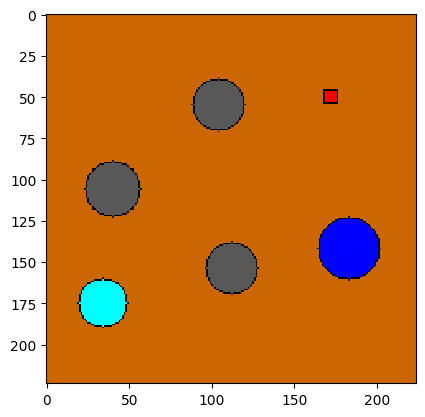

In [73]:
env = ToyEnv(7)
env.display()

For the purpose of this notebook, our "perception" module is just looking up the metadata to return the queried object's properties, such as 2D position ``get_pos``, pixel-level mask ``get_mask`` and size ``get_param`` (radius for bowl, side length for block)

In [60]:
# "Perception" API

def get_pos(query):
    metadata = env.metadata
    # return position of queried object
    all_objs = [o['object'] for o in metadata]
    if query not in all_objs:
        raise ValueError(f'{query} doesnt exist in scene')
    return metadata[all_objs.index(query)]['pos'] # assuming uniqueness

def get_mask(query):
    metadata = env.metadata
    # return np.uint8 mask of queried object
    all_objs = [o['object'] for o in metadata]
    if query not in all_objs:
        raise ValueError(f'{query} doesnt exist in scene')
    return metadata[all_objs.index(query)]['mask'] # assuming uniqueness


def get_param(query):
    metadata = env.metadata
    # return position of queried object
    all_objs = [o['object'] for o in metadata]
    if query not in all_objs:
        raise ValueError(f'{query} doesnt exist in scene')
    return metadata[all_objs.index(query)]['param'] # assuming uniqueness

[112, 154]
16


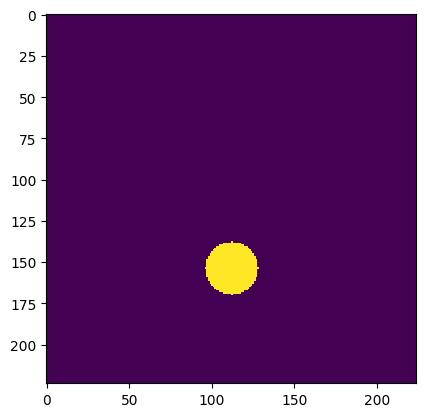

In [74]:
print(get_pos('gray bowl'))
print(get_param('gray bowl'))
env.show(get_mask('gray bowl'))

Similarly, our ``pick_and_place`` control primitive is simulated with just deleting the object and respawning it in the target position.

In [75]:
# "Control" API

def show_action(before, after, title):
    before = cv2.cvtColor(before, cv2.COLOR_BGR2RGB)
    after = cv2.cvtColor(after, cv2.COLOR_BGR2RGB)  
    f = plt.figure()
    f.suptitle(title, fontsize=12)
    f.add_subplot(1,2, 1)
    plt.title('before')
    plt.imshow(before)
    f.add_subplot(1,2, 2)
    plt.title('after')
    plt.imshow(after)
    plt.show(block=True)

    
def pick_and_place(source, 
                   target,
                   display=True
):
    scene, metadata = env.get_state()
    assert isinstance(source, str), 'first argument is object description'
    before = scene.copy()
    all_objs = [o['object'] for o in metadata]
    source_mask, source_param = get_mask(source), get_param(source)
    # delete it from scene while leaving other objects intact
    #scene[source_mask == 0xff] = 0
    scene = env.spawn_table()
    _ = metadata.pop(all_objs.index(source)) # assuming uniqueness
    for obj in metadata:
        _color, _shape = obj['object'].split()
        _pos, _param = obj['pos'], obj['param']
        scene, _ = eval(f'env.draw_{_shape}')(scene, _pos, _color, _param)
    # paste it in target position
    target_pos = get_pos(target) if isinstance(target, str) else target 
    color, shape = source.split()
    scene, target_mask = eval(f'env.draw_{shape}')(scene, target_pos, color, source_param)
    metadata.append({'object': source, 'pos': target_pos, 'mask': target_mask, 'param':source_param})
    if display:
        show_action(before, scene.copy(), f"pick_and_place({source}, {target})")
    env.set_state(scene, metadata)

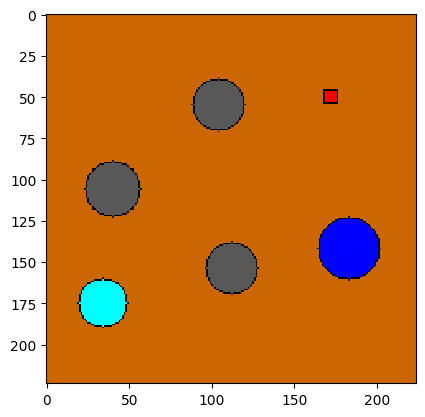

In [76]:
#env.reset(8)
env.display()

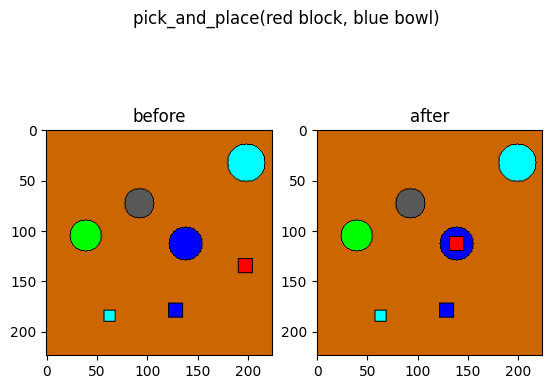

In [64]:
pick_and_place('red block', 'blue bowl')

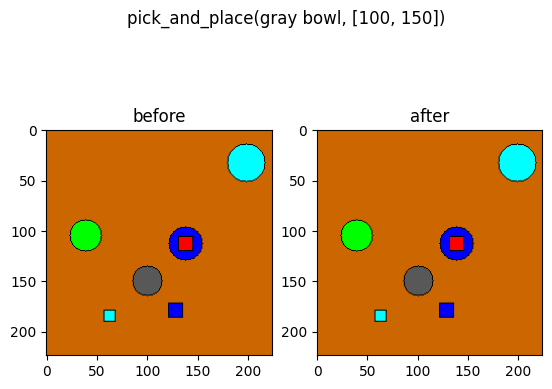

In [67]:
pick_and_place('gray bowl', [100, 150])

In [77]:
pick_and_place('gray block', 'gray bowl')
pick_and_place('blue block', 'gray bowl')
pick_and_place('cyan block', 'gray bowl')
pick_and_place('blue bowl', [112,112])
pick_and_place('blue bowl', [112, 112])


ValueError: gray block doesnt exist in scene

We can control a "robot" for tabletop pick&place tasks. Can we use Bloom to parse arbitrary task descriptions to executable Python programs using our primitive APIs?

# Interactive Tabletop Manipulation

Adapt from [here](https://github.com/google-research/google-research/blob/master/code_as_policies/Interactive_Demo.ipynb)